In [1]:
import tensorflow as tf
import tensorflow_io as tfio
from matplotlib import pyplot as plt
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

In [2]:
print(tf.__version__)


2.11.0


In [3]:
capuchin_file = os.path.join('data', "Parsed_Capuchinbird_Clips", "XC3776-3.wav")
Not_capuchin_file = os.path.join('data', "Parsed_Not_Capuchinbird_Clips", "afternoon-birds-song-in-forest-0.wav")

In [4]:
capuchin_file

'data\\Parsed_Capuchinbird_Clips\\XC3776-3.wav'

In [5]:
def load_wav_16k_mono(filename):
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [6]:
wave = load_wav_16k_mono(capuchin_file)

nwave = load_wav_16k_mono(Not_capuchin_file)
 

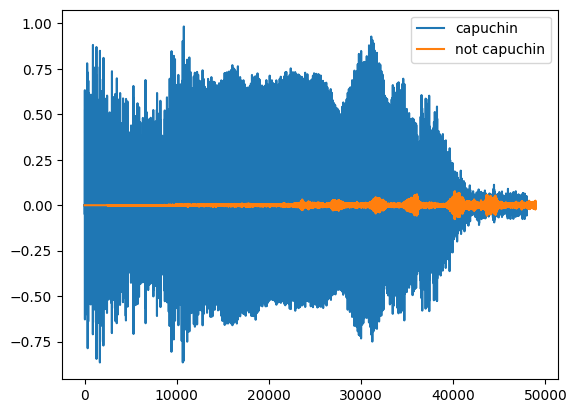

In [7]:
plt.plot(wave, label='capuchin')
plt.plot(nwave, label='not capuchin')
plt.legend()
plt.show()

In [8]:
pos_path = os.path.join('data', "Parsed_Capuchinbird_Clips")
neg_path = os.path.join('data', "Parsed_Not_Capuchinbird_Clips") 

In [9]:
pos = tf.data.Dataset.list_files(pos_path + '\*.wav')
neg = tf.data.Dataset.list_files(neg_path + '\*.wav')

In [10]:
pos.as_numpy_iterator().next()

b'data\\Parsed_Capuchinbird_Clips\\XC395129-0.wav'

In [11]:
len(neg)

593

In [12]:
positives = tf.data.Dataset.zip((pos,tf.data.Dataset.from_tensor_slices(tf.ones(len(pos))))) 
negatives = tf.data.Dataset.zip((neg,tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg))))) 
data = positives.concatenate(negatives) 

In [13]:
data.shuffle(1000).as_numpy_iterator().next()

(b'data\\Parsed_Capuchinbird_Clips\\XC456236-2.wav', 1.0)

In [14]:

lengths = []
for file in os.listdir(os.path.join('data', 'Parsed_Capuchinbird_Clips')):
    tensor_wave = load_wav_16k_mono(os.path.join('data', 'Parsed_Capuchinbird_Clips', file))
    lengths.append(len(tensor_wave))

In [15]:
len(lengths)

217

In [16]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [17]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [18]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

In [19]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [20]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

spectrogram, label = preprocess(filepath, label)

In [21]:
spectrogram.shape

TensorShape([1491, 257, 1])

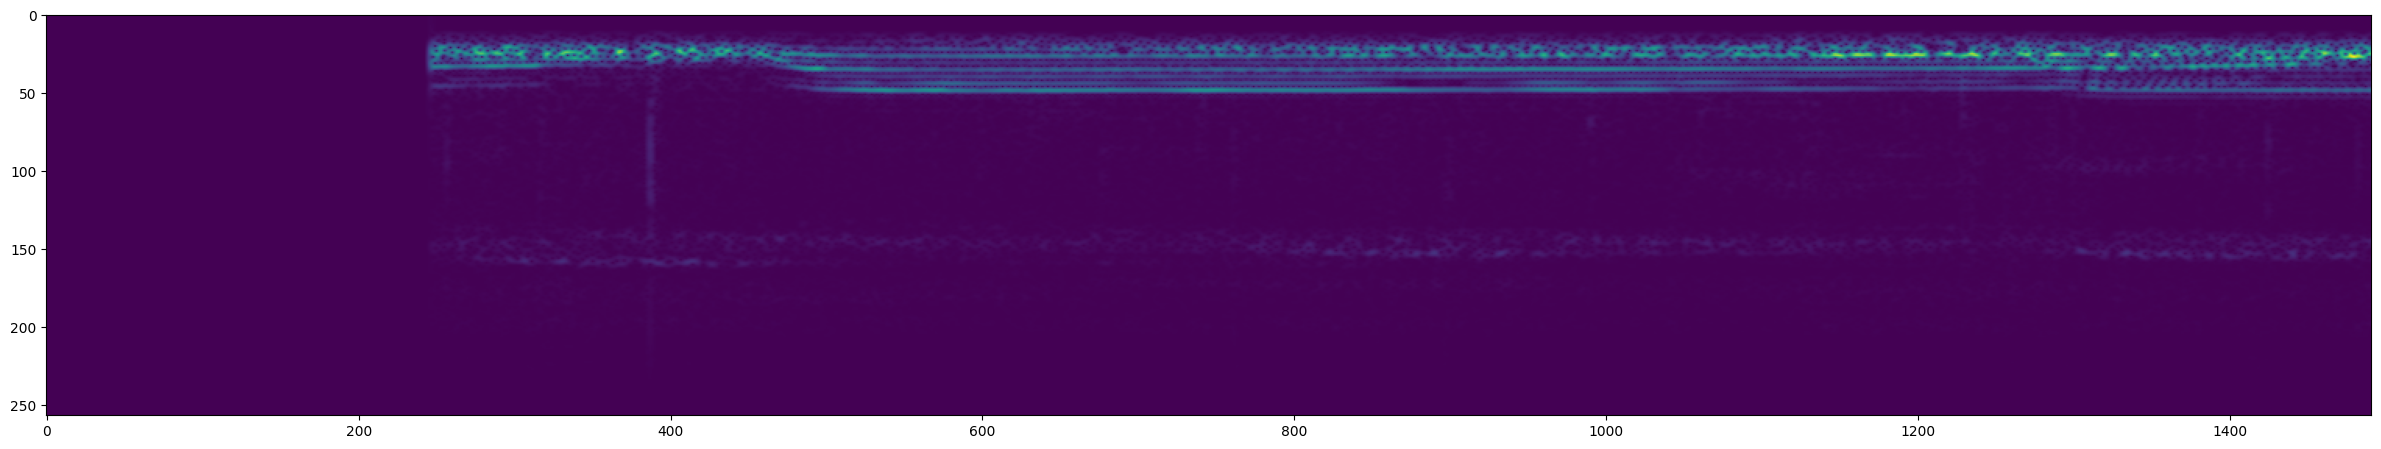

In [22]:
plt.figure(figsize=(30, 20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [23]:
data = data.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
data = data.cache()
data = data.shuffle(buffer_size=500)  # Lower buffer size
data = data.batch(8)  # Reduce batch size
data = data.prefetch(tf.data.AUTOTUNE)  # Auto-tune prefetching


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [24]:
len(data)

102

In [25]:
train = data.take(36)
test = data.skip(36).take(15)

In [26]:
samples, lables = train.as_numpy_iterator().next() 
samples.shape

(8, 1491, 257, 1)

In [27]:
model = Sequential()
model.add(Conv2D(8, (3,3), activation='relu', input_shape=(1491, 257,1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [28]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])


In [29]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 8)      80        
                                                                 
 conv2d_1 (Conv2D)           (None, 1487, 253, 16)     1168      
                                                                 
 flatten (Flatten)           (None, 6019376)           0         
                                                                 
 dense (Dense)               (None, 64)                385240128 
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 385,241,441
Trainable params: 385,241,441
Non-trainable params: 0
_________________________________________________________________


Epoch 1/4
36/36 [==============================] - 306s 8s/step - loss: 12.6621 - recall: 0.8462 - precision: 0.7938 - val_loss: 3.3462 - val_recall: 0.9375 - val_precision: 0.8333
Epoch 2/4
36/36 [==============================] - 292s 7s/step - loss: 0.5835 - recall: 0.9368 - precision: 0.9570 - val_loss: 0.0837 - val_recall: 0.9615 - val_precision: 1.0000
Epoch 3/4
36/36 [==============================] - 230s 6s/step - loss: 0.1630 - recall: 0.9604 - precision: 0.9798 - val_loss: 0.0174 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 4/4
36/36 [==============================] - 216s 5s/step - loss: 0.5344 - recall: 0.9634 - precision: 0.9875 - val_loss: 0.0196 - val_recall: 0.9600 - val_precision: 1.0000


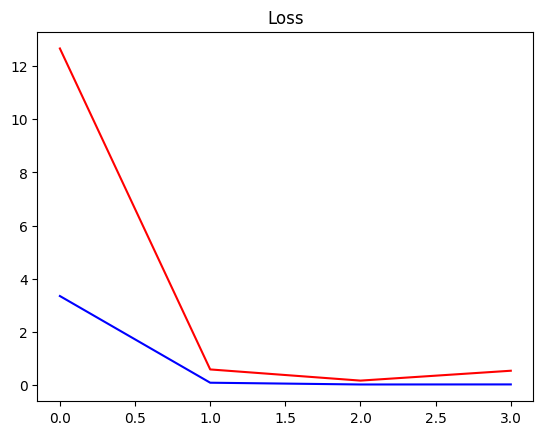

In [30]:
hist = model.fit(train, epochs=4, validation_data=test)

plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

In [73]:
X_test, y_test = test.as_numpy_iterator().next()


In [74]:
y_test.shape

(8,)

In [75]:
yhat = model.predict(X_test)


1/1 [==============================] - 0s 190ms/step


In [76]:
yhat

array([[2.7106703e-23],
       [7.6866804e-24],
       [1.8859454e-09],
       [4.1146709e-06],
       [1.0000000e+00],
       [3.6056741e-30],
       [3.1940177e-05],
       [6.9413596e-07]], dtype=float32)

In [77]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]


In [78]:
y_test.astype(int)

array([0, 0, 0, 0, 1, 0, 0, 0])

In [79]:
yhat

[0, 0, 0, 0, 1, 0, 0, 0]

In [80]:

def load_mp3_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    res = tfio.audio.AudioIOTensor(filename)
    # Convert to tensor and combine channels 
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2 
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample to 16 kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [81]:

mp3 = os.path.join('data', 'Forest Recordings', 'recording_00.mp3')

In [82]:

wav = load_mp3_16k_mono(mp3)

In [83]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)


In [84]:
samples, index = audio_slices.as_numpy_iterator().next()


In [85]:
samples.shape

(1, 48000)

In [87]:
len(audio_slices)

60

In [88]:

def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

In [89]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=16000, sequence_stride=16000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [90]:

yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.99 else 0 for prediction in yhat]

3/3 [==============================] - 5s 990ms/step


In [91]:
from itertools import groupby

In [92]:

yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()

In [93]:

calls

5

In [94]:
results = {}
for file in os.listdir(os.path.join('data', 'Forest Recordings')):
    FILEPATH = os.path.join('data','Forest Recordings', file)
    
    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)
    
    yhat = model.predict(audio_slices)
    
    results[file] = yhat

1/1 [==============================] - 1s 1s/step


In [95]:

results

{'recording_00.mp3': array([[1.04406901e-01],
        [7.85956979e-02],
        [1.56164750e-01],
        [7.13616729e-01],
        [1.00000000e+00],
        [3.10517591e-03],
        [5.05353957e-02],
        [9.59985703e-02],
        [4.19459678e-02],
        [1.18723974e-01],
        [8.60860869e-02],
        [7.51331151e-02],
        [7.51095340e-02],
        [9.99997735e-01],
        [1.00000000e+00],
        [6.80198818e-02],
        [1.25796973e-07],
        [3.93051244e-02],
        [9.89091396e-02],
        [8.70193765e-02],
        [1.25678942e-01],
        [3.91495973e-02],
        [1.12056419e-01],
        [5.04378796e-01],
        [1.00000000e+00],
        [8.49832955e-04],
        [7.76840514e-03],
        [1.44181654e-01],
        [5.05927429e-02],
        [1.28162175e-01],
        [4.78622504e-02],
        [1.48299098e-01],
        [2.95880158e-03],
        [3.75905220e-04],
        [1.69184014e-01],
        [2.02353746e-02],
        [1.00000000e+00],
        [1.0950963

In [96]:

class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
class_preds

{'recording_00.mp3': [0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_01.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_02.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_03.mp3': [0,
  0,
  0,
  

In [97]:

postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

{'recording_00.mp3': 5,
 'recording_01.mp3': 0,
 'recording_02.mp3': 0,
 'recording_03.mp3': 0,
 'recording_04.mp3': 4,
 'recording_05.mp3': 0,
 'recording_06.mp3': 5,
 'recording_07.mp3': 2,
 'recording_08.mp3': 25,
 'recording_09.mp3': 0,
 'recording_10.mp3': 5,
 'recording_11.mp3': 3,
 'recording_12.mp3': 0,
 'recording_13.mp3': 0,
 'recording_14.mp3': 0,
 'recording_15.mp3': 2,
 'recording_16.mp3': 4,
 'recording_17.mp3': 3,
 'recording_18.mp3': 2,
 'recording_19.mp3': 0,
 'recording_20.mp3': 0,
 'recording_21.mp3': 1,
 'recording_22.mp3': 2,
 'recording_23.mp3': 5,
 'recording_24.mp3': 0,
 'recording_25.mp3': 14,
 'recording_26.mp3': 2,
 'recording_27.mp3': 0,
 'recording_28.mp3': 14,
 'recording_29.mp3': 0,
 'recording_30.mp3': 1,
 'recording_31.mp3': 1,
 'recording_32.mp3': 2,
 'recording_33.mp3': 0,
 'recording_34.mp3': 4,
 'recording_35.mp3': 0,
 'recording_36.mp3': 0,
 'recording_37.mp3': 3,
 'recording_38.mp3': 1,
 'recording_39.mp3': 12,
 'recording_40.mp3': 1,
 'recording_

In [98]:

import csv

In [99]:

with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])

In [102]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import csv

In [103]:
y_true = []
y_pred = []
for X_test, y_test in test:
    yhat = model.predict(X_test)
    y_pred.extend([1 if prediction > 0.5 else 0 for prediction in yhat])
    y_true.extend(y_test.numpy())


1/1 [==============================] - 0s 195ms/step


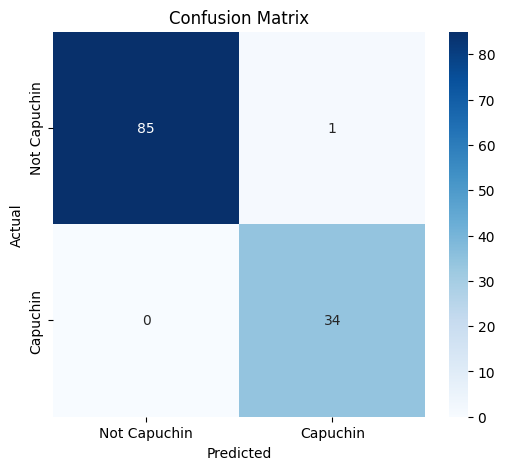

In [104]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Capuchin', 'Capuchin'], yticklabels=['Not Capuchin', 'Capuchin'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Save model
model.save('capuchin_model.h5')
